In [143]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.externals import joblib
from sklearn.svm import SVC
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

In [144]:
train_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\train.csv")
test_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\test.csv")

In [145]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers out there! I know it's hard not being able to see your mothers today but it's on all of us to do what we can to protect the most vulnerable members of our society. #BeatCoronaVirus pic.twitter.com/va4nFjFQ5B,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be there to bring you Mothers day flowers & a cwtch - honestly at this point I'd walk on hot coals to be able to. But I'll be there with bells on as soon as I can be. Love you lots xxx (p.s we need more photos!) https:// photos.app.goo.gl/M3vXBLrsCzD4TE bY7 …,en,1,FestiveFeeling,0
2,1.246087e+18,"Happy mothers day To all This doing a mothers days work. Today been quiet but Had time to reflect. Dog walk, finish a jigsaw do the garden, learn few more guitar chords, drunk some strawberry gin and tonic and watch Lee evens on DVD. My favourite place to visit. #isolate pic.twitter.com/GZ0xVvF6f9",en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...royalty soothes you mummy jeremy and emerald and more #PrayForRoksie #UltimateLoveNG pic.twitter.com/oeetI22Pvv,en,0,Queenuchee,0
4,1.244876e+18,"Remembering the 3 most amazing ladies who made me who I am! My late grandmother iris, mum carol and great grandmother Ethel. Missed but never forgotten! Happy mothers day to all those great mums out there! Love sent to all xxxx pic.twitter.com/xZZZdEybjE",en,0,brittan17446794,-1


In [146]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3235 non-null   float64
 1   original_text    3235 non-null   object 
 2   lang             3231 non-null   object 
 3   retweet_count    3231 non-null   object 
 4   original_author  3235 non-null   object 
 5   sentiment_class  3235 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 151.8+ KB


In [147]:
temp = train_data.groupby('sentiment_class').count()['original_text'].reset_index().sort_values(by='original_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment_class,original_text
1,0,1701
0,-1,769
2,1,765


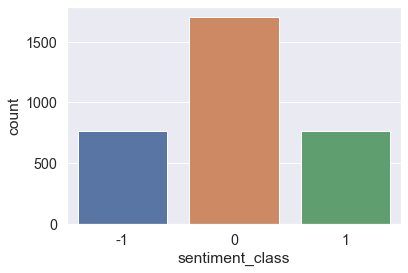

In [148]:
sns.countplot(x='sentiment_class',data=train_data)

In [149]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [150]:
tc = TextCounts()
df_eda = tc.fit_transform(train_data.original_text)
train_data=pd.concat([train_data,df_eda],axis=1)

In [151]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,1.245025e+18,Happy #MothersDay to all you amazing mothers out there! I know it's hard not being able to see your mothers today but it's on all of us to do what we can to protect the most vulnerable members of our society. #BeatCoronaVirus pic.twitter.com/va4nFjFQ5B,en,0,BeenXXPired,0,48,0,2,0,1,0,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be there to bring you Mothers day flowers & a cwtch - honestly at this point I'd walk on hot coals to be able to. But I'll be there with bells on as soon as I can be. Love you lots xxx (p.s we need more photos!) https:// photos.app.goo.gl/M3vXBLrsCzD4TE bY7 …,en,1,FestiveFeeling,0,65,0,0,0,1,0,0
2,1.246087e+18,"Happy mothers day To all This doing a mothers days work. Today been quiet but Had time to reflect. Dog walk, finish a jigsaw do the garden, learn few more guitar chords, drunk some strawberry gin and tonic and watch Lee evens on DVD. My favourite place to visit. #isolate pic.twitter.com/GZ0xVvF6f9",en,0,KrisAllenSak,-1,54,0,1,1,0,0,0
3,1.244803e+18,Happy mothers day to this beautiful woman...royalty soothes you mummy jeremy and emerald and more #PrayForRoksie #UltimateLoveNG pic.twitter.com/oeetI22Pvv,en,0,Queenuchee,0,22,0,2,0,0,0,0
4,1.244876e+18,"Remembering the 3 most amazing ladies who made me who I am! My late grandmother iris, mum carol and great grandmother Ethel. Missed but never forgotten! Happy mothers day to all those great mums out there! Love sent to all xxxx pic.twitter.com/xZZZdEybjE",en,0,brittan17446794,-1,45,0,0,0,3,0,0


In [152]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment_class')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment_class', size=5, hue='sentiment_class', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

In [153]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [154]:
ct = CleanText()
train_data['original_text'] = ct.fit_transform(train_data.original_text)

In [155]:
train_data["clean_text"]= train_data["original_text"].str.replace("mum", "mother", case = False)
train_data["clean_text"]= train_data["clean_text"].str.replace("mom", "mother", case = False)
train_data["clean_text"]= train_data["clean_text"].str.replace("mothersday","mother day") 
train_data["clean_text"]= train_data["clean_text"].str.replace("httpswww","") 
train_data["clean_text"]= train_data["clean_text"].str.replace("http","") 
train_data["clean_text"]= train_data["clean_text"].str.replace("u","") 

In [156]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [157]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['id','original_text','sentiment_class','lang','original_author'],axis=1), train_data.sentiment_class, test_size=0.2, random_state=37)

In [158]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=None):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([('features', features),('clf', clf)])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5)
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [159]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2),(1,3)),
    'features__pipe__vect__min_df': (1,2)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.1, 0.25, 0.5, 0.75, 1.0),
    'clf__fit_prior' : (True,False)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2'),
    'clf__fit_intercept': (True,False)
}
parameters_sgd = {
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2','elasticnet'),
    'clf__max_iter': (10, 25, 50, 75, 100)
}
parameters_svc = {'clf__kernel': ['linear', 'rbf'],
                    'clf__gamma':[0.1,1,10],
                    'clf__C':[0.1,1,0.001,0.0001]
                 }
parameters_gbm = {'clf__loss':['deviance','exponential'],
         'clf__learning_rate': [0.05,0.1],
         'clf__max_depth':[5,10,20],
         'clf__n_estimators': [10,25,50]
        }

In [160]:
mnb = MultinomialNB()
logreg = LogisticRegression()
sgd=SGDClassifier()
svc=SVC()
gbm=GradientBoostingClassifier()


In [161]:
mnb.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [162]:
countvect = CountVectorizer()
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
prediction_mnb=best_mnb_countvect.predict(X_test)
mnb_score=100*(f1_score(y_test,prediction_mnb,average='weighted'))
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(mnb_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.0s finished


done in 17.483s

Best CV score: 0.405
Best parameters set:
	clf__alpha: 0.1
	clf__fit_prior: True
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.459


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.28      0.19      0.23       160
           0       0.54      0.70      0.61       339
           1       0.29      0.19      0.23       148

    accuracy                           0.46       647
   macro avg       0.37      0.36      0.36       647
weighted avg       0.42      0.46      0.43       647


Accuracy score of Multinomial naive bayes algorithm -----> 42.92427735584853


In [163]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
prediction_logreg = best_logreg_countvect.predict(X_test)
logreg_score=100*(f1_score(y_test,prediction_logreg,average='weighted'))
print("\nAccuracy score of Log Reg algorithm -----> " + str(logreg_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.0s finished


done in 27.987s

Best CV score: 0.404
Best parameters set:
	clf__C: 0.25
	clf__fit_intercept: True
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 1.0
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.427


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.23      0.10      0.14       160
           0       0.51      0.71      0.59       339
           1       0.20      0.14      0.17       148

    accuracy                           0.43       647
   macro avg       0.31      0.32      0.30       647
weighted avg       0.37      0.43      0.38       647


Accuracy score of Log Reg algorithm -----> 38.11999190460341


In [164]:
# SGD
best_sgd_countvect = grid_vect(sgd, parameters_sgd, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
prediction_sgd = best_sgd_countvect.predict(X_test)
sgd_score=100*(f1_score(y_test,prediction_sgd,average='weighted'))
print("\nAccuracy score of SGD algorithm -----> " + str(sgd_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.0s finished


done in 6.455s

Best CV score: 0.398
Best parameters set:
	clf__alpha: 1e-06
	clf__max_iter: 100
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.422


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.22      0.16      0.19       160
           0       0.50      0.64      0.56       339
           1       0.32      0.21      0.25       148

    accuracy                           0.42       647
   macro avg       0.35      0.34      0.33       647
weighted avg       0.39      0.42      0.40       647


Accuracy score of SGD algorithm -----> 39.80852139075023


In [165]:
# SVC
best_svc_countvect = grid_vect(svc, parameters_svc, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
prediction_svc = best_svc_countvect.predict(X_test)
svc_score=100*(f1_score(y_test,prediction_svc,average='weighted'))
print("\nAccuracy score of SVC algorithm -----> " + str(svc_score))


Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.7s finished


done in 17.596s

Best CV score: 0.391
Best parameters set:
	clf__C: 0.1
	clf__gamma: 1
	clf__kernel: 'linear'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.496


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.35      0.04      0.08       160
           0       0.52      0.92      0.66       339
           1       0.09      0.01      0.02       148

    accuracy                           0.50       647
   macro avg       0.32      0.33      0.25       647
weighted avg       0.38      0.50      0.37       647


Accuracy score of SVC algorithm -----> 37.12964577221097


In [166]:
# GBC
best_gbm_countvect = grid_vect(gbm, parameters_gb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
prediction_gbm = best_gbm_countvect.predict(X_test)
gbc_score=100*(f1_score(y_test,prediction_gbm,average='weighted'))
print("\nAccuracy score of gbc algorithm -----> " + str(gbc_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.8s finished


done in 10.623s

Best CV score: 0.394
Best parameters set:
	clf__learning_rate: 0.1
	clf__loss: 'deviance'
	clf__max_depth: 10
	clf__n_estimators: 50
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.509


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.39      0.04      0.08       160
           0       0.52      0.94      0.67       339
           1       0.14      0.02      0.04       148

    accuracy                           0.51       647
   macro avg       0.35      0.34      0.26       647
weighted avg       0.40      0.51      0.38       647


Accuracy score of gbc algorithm -----> 38.05644376588371


In [ ]:
SIZE = 50
X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))
model = gensim.models.Word2Vec(X_train.clean_text_wordlist, min_count=1, size=SIZE, window=5, workers=4)


In [ ]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [ ]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)
# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [ ]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)
prediction_w2v_logreg=best_logreg_w2v.predict(X_test_w2v)
logreg_w2v_score=100*(f1_score(y_test,prediction_w2v_logreg,average='weighted'))
print("\nAccuracy score of Log Reg algorithm -----> " + str(logreg_score))

In [ ]:
# SGD
best_sgd_w2v = grid_vect(sgd, parameters_sgd, X_train_w2v, X_test_w2v, is_w2v=True)
prediction_w2v_sgd=best_sgd_w2v.predict(X_test_w2v)
sgd_w2v_score=100*(f1_score(y_test,prediction_w2v_sgd,average='weighted'))
print("\nAccuracy score of Log Reg algorithm -----> " + str(sgd_w2v_score))


In [ ]:
# SGD
best_gbm_w2v = grid_vect(gbm, parameters_gbm, X_train_w2v, X_test_w2v, is_w2v=True)
prediction_w2v_gbm=best_gbm_w2v.predict(X_test_w2v)
gbm_w2v_score=100*(f1_score(y_test,prediction_w2v_gbm,average='weighted'))
print("\nAccuracy score of Log Reg algorithm -----> " + str(gbm_w2v_score))

In [ ]:
parameters_tfidf = {
    'features__pipe__vect__norm': ('l1','l2'),
    'features__pipe__vect__use_idf': (True,False),
    'features__pipe__vect__smooth_idf': (True,False)
}

In [ ]:
tfidf_vect = TfidfVectorizer()
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_tfidf, vect=tfidf_vect)
prediction_mnb_tfidf=best_mnb_tfidf.predict(X_test)
mnb_score_tfidf=100*(f1_score(y_test,prediction_mnb_tfidf,average='weighted'))
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(mnb_score_tfidf))


In [ ]:
# SGD
best_sgd_tfidf = grid_vect(sgd, parameters_sgd, X_train, X_test, parameters_text=parameters_tfidf, vect=tfidf_vect)
prediction_sgd_tfidf = best_sgd_tfidf.predict(X_test)
sgd_score_tfidf=100*(f1_score(y_test,prediction_sgd_tfidf,average='weighted'))
print("\nAccuracy score of SGD algorithm -----> " + str(sgd_score_tfidf))

In [ ]:
# SVC
best_svc_tfidf = grid_vect(svc, parameters_svc, X_train, X_test, parameters_text=parameters_tfidf, vect=tfidf_vect)
prediction_svc_tfidf = best_svc_tfidf.predict(X_test)
svc_score_tfidf=100*(f1_score(y_test,prediction_svc_tfidf,average='weighted'))
print("\nAccuracy score of SVC algorithm -----> " + str(svc_score_tfidf))

In [ ]:
# GBM
best_gbm_tfidf = grid_vect(gbm, parameters_gbm, X_train, X_test, parameters_text=parameters_tfidf, vect=tfidf_vect)
prediction_gbm_tfidf = best_gbm_tfidf.predict(X_test)
gbm_score_tfidf=100*(f1_score(y_test,prediction_gbm_tfidf,average='weighted'))
print("\nAccuracy score of GBM algorithm -----> " + str(gbm_score_tfidf))

In [ ]:
svc = LinearSVC(dual=False)
best_linear_svc=grid_vect(svc, parameters_svc, X_train, X_test, parameters_text=parameters_vect, vect=tfidf_vect)

In [ ]:
svc_score=100*(f1_score(y_test,prediction_mnb,average='weighted'))

In [ ]:
print("\nAccuracy score of SVC algorithm -----> " + str(svc_score))